In [297]:
import psycopg as pg
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from geopy.distance import geodesic
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
from scipy.spatial.distance import cdist, pdist
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from mpl_toolkits.basemap import Basemap
import copy
import json
import math
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
from datetime import timezone, datetime
import pytz
 
%matplotlib inline

In [298]:
connection = pg.connect(
    host="localhost",
    port="5432",
    dbname="NYCBikes",  # Replace with your actual database
    user="postgres",
    password="postgres"
)


In [299]:
# Query to fetch spatial heatmap data with timestamps
query = """
    SELECT * 
    FROM  station_information  
"""

query1 = """
    SELECT * 
    FROM  station_flow  
"""

dfStInf = pd.read_sql_query(query, connection)
dfStFlow = pd.read_sql_query(query1, connection)

print(f"Finished reading {len(dfStInf)}")
print(f"Finished reading {len(dfStFlow)}")
# Close the connection
connection.close()

Finished reading 2143
Finished reading 3185984


In [300]:
dfStFlow.head()

,station_id,start_time,in_count,out_count
0,2733.03,2024-03-01 05:00:00+00:00,0,0
1,2733.03,2024-03-01 05:30:00+00:00,0,0
2,2733.03,2024-03-01 06:00:00+00:00,0,0
3,2733.03,2024-03-01 06:30:00+00:00,0,0
4,2733.03,2024-03-01 07:00:00+00:00,0,0


In [301]:
dfStInf.head()

,station_id,station_name,station_lat,station_lng,geom
0,2733.03,67 St & Erik Pl,40.635560,-74.012980,0101000020767D0000D1AF58BB573E1241053C582E936C...
1,2782.02,5 Ave & 67 St,40.635679,-74.020005,0101000020767D00005A8D35910E35124157632E993D6E...
2,2821.05,7 Ave & 62 St,40.647379,-74.000911,0101000020767D00009EDD2EC84B4E1241BA8089A79F10...
3,2832.03,4 Ave & Shore Road Dr,40.679279,-73.981540,0101000020767D000090C1C384E267124127B0D2C771CB...
4,2861.02,57 St & 7 Ave,40.675833,-74.014726,0101000020767D0000BC979AC70B3C1241F9F826AF9A9B...


In [302]:
dfStInf = dfStInf.drop('geom', axis=1)

In [303]:
dfStInf.head()

,station_id,station_name,station_lat,station_lng
0,2733.03,67 St & Erik Pl,40.635560,-74.012980
1,2782.02,5 Ave & 67 St,40.635679,-74.020005
2,2821.05,7 Ave & 62 St,40.647379,-74.000911
3,2832.03,4 Ave & Shore Road Dr,40.679279,-73.981540
4,2861.02,57 St & 7 Ave,40.675833,-74.014726


In [304]:
# Convert the time from to another timezone
# The point in time does not change, only the associated timezone
my_timezone = pytz.timezone('America/New_York')
dfStFlow['start_time'] = dfStFlow['start_time'].dt.tz_convert(my_timezone)
dfStFlow.head()

,station_id,start_time,in_count,out_count
0,2733.03,2024-03-01 00:00:00-05:00,0,0
1,2733.03,2024-03-01 00:30:00-05:00,0,0
2,2733.03,2024-03-01 01:00:00-05:00,0,0
3,2733.03,2024-03-01 01:30:00-05:00,0,0
4,2733.03,2024-03-01 02:00:00-05:00,0,0


In [305]:
dfflow = dfStFlow[(dfStFlow['start_time'].dt.month == 3) & (dfStFlow['start_time'].dt.day <= 7)]
dfflow.head()

,station_id,start_time,in_count,out_count
0,2733.03,2024-03-01 00:00:00-05:00,0,0
1,2733.03,2024-03-01 00:30:00-05:00,0,0
2,2733.03,2024-03-01 01:00:00-05:00,0,0
3,2733.03,2024-03-01 01:30:00-05:00,0,0
4,2733.03,2024-03-01 02:00:00-05:00,0,0


In [306]:
df_temp = dfflow.pivot(index='station_id', columns='start_time').reset_index()
df_temp

station_id                  in_count                            \
start_time        NaT 2024-03-01 00:00:00-05:00 2024-03-01 00:30:00-05:00   
0                NaN                         0                         0   
1            2733.03                         0                         0   
2            2782.02                         0                         0   
3            2821.05                         0                         0   
4            2832.03                         0                         0   
...              ...                       ...                       ...   
2139           JC105                         0                         0   
2140           JC109                         0                         0   
2141          SYS016                         0                         1   
2142          SYS033                         0                         0   
2143          SYS038                         0                         0   

                                                               \
start_time 2024-03-01 01:00:00-05:00 2024-03-01 01:30:00-05:00   
0                                 0                         0   
1                                 0                         0   
2                                 0                         0   
3                                 0                         0   
4                                 0                         0   
...                             ...                       ...   
2139                              0                         0   
2140                              0                         0   
2141                              0                         0   
2142                              0                         0   
2143                              0                         0   

                                                               \
start_time 2024-03-01 02:00:00-05:00 2024-03-01 02:30:00-05:00   
0                                 0                         0   
1                                 0                         0   
2                                 0                         0   
3                                 1                         0   
4                                 0                         0   
...                             ...                       ...   
2139                              0                         0   
2140                              0                         0   
2141                              0                         0   
2142                              0                         0   
2143                              0                         0   

                                                               \
start_time 2024-03-01 03:00:00-05:00 2024-03-01 03:30:00-05:00   
0                                 0                         0   
1                                 0                         0   
2                                 0                         0   
3                                 0                         0   
4                                 0                         0   
...                             ...                       ...   
2139                              0                         0   
2140                              0                         0   
2141                              0                         0   
2142                              0                         0   
2143                              0                         0   

                                     ...                 out_count  \
start_time 2024-03-01 04:00:00-05:00  ... 2024-03-07 19:00:00-05:00   
0                                 0  ...                         0   
1                                 0  ...                         0   
2                                 0  ...                         0   
3                                 0  ...                         1   
4                                 0  ...                  

In [307]:
df_temp = df_temp.drop(df_temp.index[0])
df_temp.head()

station_id                  in_count                            \
start_time        NaT 2024-03-01 00:00:00-05:00 2024-03-01 00:30:00-05:00   
1            2733.03                         0                         0   
2            2782.02                         0                         0   
3            2821.05                         0                         0   
4            2832.03                         0                         0   
5            2861.02                         0                         0   

                                                               \
start_time 2024-03-01 01:00:00-05:00 2024-03-01 01:30:00-05:00   
1                                 0                         0   
2                                 0                         0   
3                                 0                         0   
4                                 0                         0   
5                                 0                         0   

                                                               \
start_time 2024-03-01 02:00:00-05:00 2024-03-01 02:30:00-05:00   
1                                 0                         0   
2                                 0                         0   
3                                 1                         0   
4                                 0                         0   
5                                 0                         0   

                                                               \
start_time 2024-03-01 03:00:00-05:00 2024-03-01 03:30:00-05:00   
1                                 0                         0   
2                                 0                         0   
3                                 0                         0   
4                                 0                         0   
5                                 0                         0   

                                     ...                 out_count  \
start_time 2024-03-01 04:00:00-05:00  ... 2024-03-07 19:00:00-05:00   
1                                 0  ...                         0   
2                                 0  ...                         0   
3                                 0  ...                         1   
4                                 0  ...                         0   
5                                 0  ...                         0   

                                                               \
start_time 2024-03-07 19:30:00-05:00 2024-03-07 20:00:00-05:00   
1                                 0                         0   
2                                 0                         0   
3                                 1                         0   
4                                 0                         3   
5                                 0                         0   

                                                               \
start_time 2024-03-07 20:30:00-05:00 2024-03-07 21:00:00-05:00   
1                                 0                         0   
2                                 0                         0   
3                                 0                         0   
4                                 0                         0   
5                                 0                         0   

                                                               \
start_time 2024-03-07 21:30:00-05:00 2024-03-07 22:00:00-05:00   
1                                 0                         0   
2                                 0                         0   
3                                 0                         0   
4                                 0                         0   
5                                 0                         0   

                                                               \
start_time 2024-03-07 22:30:00-05:00 2024-03-07 23:00:00-05:00   
1                                 0                         0   
2                                 0           

In [308]:
df_All= dfStInf.merge(df_temp.droplevel(1, axis=1), on=['station_id'], how ='left')

In [284]:
df_All

,station_id,station_name,station_lat,station_lng,in_count,in_count,in_count,in_count,in_count,in_count,...,out_count,out_count,out_count,out_count,out_count,out_count,out_count,out_count,out_count,out_count
0,2733.03,67 St & Erik Pl,40.635560,-74.012980,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2782.02,5 Ave & 67 St,40.635679,-74.020005,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2821.05,7 Ave & 62 St,40.647379,-74.000911,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2832.03,4 Ave & Shore Road Dr,40.679279,-73.981540,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2861.02,57 St & 7 Ave,40.675833,-74.014726,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2138,JC105,Hoboken Ave at Monmouth St,40.750604,-74.024020,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2139,JC109,Bergen Ave & Sip Ave,40.725726,-74.071959,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2140,SYS016,Morgan Bike Mechanics,40.701080,-73.917900,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2141,SYS033,Pier 40 X2,40.729170,-73.998102,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [309]:
X = dfStInf[['station_lat', 'station_lng']].values
X
len(X)

2143

In [310]:
Ks = range(1, 10)
Ks

range(1, 10)

In [311]:
Ks = range(1, 10)
kmean = [KMeans(n_clusters=i).fit(X) for i in Ks]

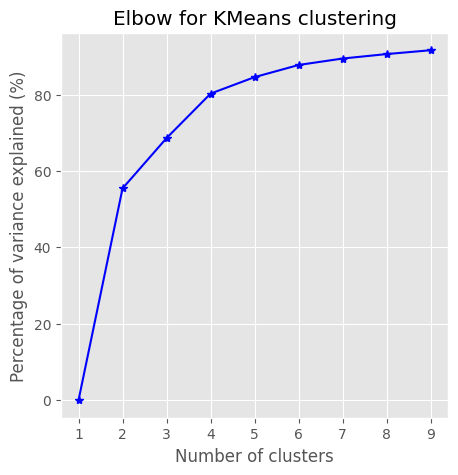

In [312]:
def plot_elbow(kmean, X):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(X, center, 'euclidean') for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering')
    plt.savefig('/Users/avaisman/tmp/PythonNotebooks/Figs/elbow.svg', format="svg", orientation ='landscape',bbox_inches ="tight", edgecolor ='g', dpi=250)
    plt.show()

plot_elbow(kmean, X)

In [313]:
 def plot_stations_map(ax, stns):
    # determine range to print based on min, max lat and lon of the data
    lat = list(stns['station_lat'])
    lon = list(stns['station_lng'])
    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    # create map using BASEMAP
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max - lon_min)/2,
                projection='lcc',
                resolution = 'f',)

    m.drawcoastlines()
    m.fillcontinents(lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')
    m.drawrivers()    
    
    # plot points
    clist = list(stns['cluster'].unique())
    if -1 in clist:
        clist.remove(-1)
    k = len(clist)
    colors = iter(cm.Set1(np.linspace(0, 1, max(10, k))))
    for i in range(k):
        color = next(colors)
        df = stns.loc[stns['cluster'] == clist[i]]        
        #print("Cluster {} has {} samples.".format(clist[i], df.shape[0]))
        
        # convert lat and lon to map projection coordinates
        lons, lats = m(list(df['station_lng']), list(df['station_lat']))        
        ax.scatter(lons, lats, marker = 'o', color=color, edgecolor='gray', zorder=5, alpha=1.0, s=15)

In [111]:
 TEMPORAL CLUSTERING

In [315]:
len(df_All)

2143

In [228]:
n_components = 30
pca = PCA(n_components=n_components)
pca.fit(X)
X_pca = pca.transform(X)
len(X_pca)

2143

In [ ]:
SPATIOTEMPORAL K-MEANS

In [328]:
X1 = df_temp.drop(["station_id"], axis=1).values
len(X)

array([[ 40.63556   , -74.01298   ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 40.635679  , -74.020005  ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 40.647379  , -74.000911  ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 40.70108   , -73.9179    ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 40.72917025, -73.99810231,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 40.700119  , -73.9862    ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [357]:
df_Nulls = df_All.isnull()

In [362]:
df_Nulls[df_Nulls["station_id"] == True]

,station_id,station_name,station_lat,station_lng,in_count,in_count,in_count,in_count,in_count,in_count,...,out_count,out_count,out_count,out_count,out_count,out_count,out_count,out_count,out_count,out_count
21,True,True,False,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [433]:
df_All_Clean = df_All.drop(df_All.index[21])
df_All_Clean.head()

,station_id,station_name,station_lat,station_lng,in_count,in_count,in_count,in_count,in_count,in_count,...,out_count,out_count,out_count,out_count,out_count,out_count,out_count,out_count,out_count,out_count
0,2733.03,67 St & Erik Pl,40.635560,-74.012980,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2782.02,5 Ave & 67 St,40.635679,-74.020005,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2821.05,7 Ave & 62 St,40.647379,-74.000911,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2832.03,4 Ave & Shore Road Dr,40.679279,-73.981540,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2861.02,57 St & 7 Ave,40.675833,-74.014726,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [434]:
len(df_All_Clean)

2142

In [435]:
X = df_All_Clean.drop(["station_id", "station_name"], axis=1).values
len(X)

2142

In [436]:
df_All_Clean 

,station_id,station_name,station_lat,station_lng,in_count,in_count,in_count,in_count,in_count,in_count,...,out_count,out_count,out_count,out_count,out_count,out_count,out_count,out_count,out_count,out_count
0,2733.03,67 St & Erik Pl,40.635560,-74.012980,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2782.02,5 Ave & 67 St,40.635679,-74.020005,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2821.05,7 Ave & 62 St,40.647379,-74.000911,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2832.03,4 Ave & Shore Road Dr,40.679279,-73.981540,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2861.02,57 St & 7 Ave,40.675833,-74.014726,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2138,JC105,Hoboken Ave at Monmouth St,40.750604,-74.024020,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2139,JC109,Bergen Ave & Sip Ave,40.725726,-74.071959,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2140,SYS016,Morgan Bike Mechanics,40.701080,-73.917900,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2141,SYS033,Pier 40 X2,40.729170,-73.998102,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [437]:
def combine_spatial_temporal(X, n_temporal):
    pca = PCA(n_components=n_temporal)
    X_pca = pca.fit_transform(X[:, 2:])
    X = np.hstack((X[:, :2], X_pca))
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    return X_std

In [380]:
combine_spatial_temporal(X, 2)

array([[-1.89626896, -1.67806282, -0.7418066 ,  0.08647765],
       [-1.89423411, -1.86254174, -0.68932278, -0.02677342],
       [-1.69416908, -1.36112672, -0.59178755, -0.38288025],
       ...,
       [-0.77590477,  0.81877074, -0.78221184,  0.06352301],
       [-0.29557342, -1.28736955, -0.79881831,  0.07622716],
       [-0.79233746, -0.97481079, -0.78513689,  0.11715173]])

In [431]:
def plot_spatial_temporal_clustering_result(kmean, n_components, k, Xs, df_all):
    n = len(n_components)
    plt.subplots(nrows=1, ncols=n, figsize=(20, 15))

    for i in range(n):
        est = kmean[i]
        df_all['cluster'] = est.predict(Xs[i]).tolist()
        ax = plt.subplot(1, n, 1*i+1)
        #ax.set_title("Spatial-Temporal Clustering with KMeans (#temporal features={}, k={})".format(n_components[i], k)) 
        plot_stations_map(ax, df_all)
    plt.savefig('/Users/avaisman/Dropbox/MobilityBook/Figs/MobilityAnalysis/spatiotempkmeans_2-15-30.pdf', format="pdf",bbox_inches ="tight",dpi=250)
    plt.show()
        #ax = plt.subplot(n, 1, 1*i+1)
        #ax.set_title("Average Flow for each cluster (#temporal features={}, k={})".format(n_components[i], k))
        #plot_flow_lines(ax, df_all) 

In [439]:
k = 3 
n_components = [2, 15, 30]
Xs = [combine_spatial_temporal(X, i) for i in n_components]

In [ ]:
kmean = [KMeans(n_clusters=k).fit(data) for data in Xs]
plot_spatial_temporal_clustering_result(kmean, n_components, k, Xs, df_All_Clean) 